# Process Raw Sensor Data Collected by Master_Script.py

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from datetime import datetime
import csv

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pdb

In [2]:
def reward_occupancy(observation_sequence, reward_type = 'IR_distance'):
        """
        Calculate reward based on occupancy i.e. the IRs data
        
        Args:
            observation_sequence (pd.DataFrame): observation
                1st column      : observation['timestamp']
                2nd-25th columns: 24 IRs
        Kwargs:
            reward_type (string): reward type
                1. 'IR_distance': based on IR distance from detected object to IR
                2. 'IR_state_ratio': the ratio of # of detected objects and all # 
                                     of IR sensors 
                3. 'IR_state_number': the number of detected objects
        
        Returns:
            observation_sequence (pd.DataFrame): add reward of each observation as a column 'reward_IR_distance'
                last column: observation_sequence['reward_IR_distance']
        """
        # Make here insistent with IR data
        #   1. 'IR_distance': based on IR distance from detected object to IR
        #   2. 'IR_state_ratio': the ratio of # of detected objects and all # 
        #                        of IR sensors 
        #   3. 'IR_state_number': the number of detected objects
        
        if reward_type == 'IR_distance':
            observation_sequence['reward_IR_distance'] = observation_sequence.iloc[:, 1:1+24].sum(axis=1)
        elif reward_type == 'IR_state_ratio':
            # TODO:
            pass
        elif reward_type == 'IR_state_number':
            # TODO:
            pass
        else:
            raise Exception('Please choose a proper reward type!')
        
        return observation_sequence

#### Load Raw Sensor Data Collected by Master_Script.py
1. load sensro data
2. Get start time
3. Convert relative time to timestamp
4. Convert timestamp to readable datatime
5. Drop last column which contain NON
6. Filter out data outside [1pm, 4pm]
7. Calculate reward

In [3]:
import glob
raw_sensor_data_files = glob.glob('raw_sensor_data_from_master_script/*.csv')
raw_sensor_data_files.sort()
raw_sensor_data = {}
for file in raw_sensor_data_files:
    print('Loading: {}'.format(file))
    # 1. load sensro data
    raw_sensor_data[file] = pd.read_csv(file, skiprows=4)
    
    # 2. Get start time
    with open(file, newline='') as f:
        reader = csv.reader(f)
        for i in range(4):
            tmp = next(reader)
            #print(tmp)
            if i == 2:
                line_with_time = tmp
    _, start_time = line_with_time[0].split(':')
    datetime_format = '%Y-%m-%d %H:%M:%S'
    start_time = float(start_time)
    start_time_datetime_format = datetime.fromtimestamp(start_time).strftime(datetime_format)
    #print('start_time_datetime_format = {}'.format(start_time_datetime_format))
    
    # 3. Convert relative time to timestamp
    raw_sensor_data[file]['timestamp'] = start_time + raw_sensor_data[file]['timestamp']
    
    # 4. Convert timestamp to readable datatime
    raw_sensor_data[file]['timestamp'] = raw_sensor_data[file]['timestamp'].apply(pd.Timestamp.fromtimestamp)
    
    
    # 5. drop last column which contain NON
    raw_sensor_data[file] = raw_sensor_data[file].drop([raw_sensor_data[file].columns[-1]], axis=1)
    
    # 6. filter out data outside [1pm, 4pm]
    date, time = start_time_datetime_format.split(' ')
    raw_sensor_data[file] = raw_sensor_data[file].loc[(raw_sensor_data[file]['timestamp'] >= date+' '+'13:00:00') & (raw_sensor_data[file]['timestamp'] <= date+' '+'16:00:00')]
    
    # 7. clculate reward
    raw_sensor_data[file] = reward_occupancy(raw_sensor_data[file], reward_type = 'IR_distance')
    
    # reset index to start from 0
    raw_sensor_data[file] = raw_sensor_data[file].reset_index()
    raw_sensor_data[file] = raw_sensor_data[file].drop([raw_sensor_data[file].columns[0]], axis=1)
    #print('Loading: done')

Loading: raw_sensor_data_from_master_script/sensor_data__September_14_2018_at_09-00-00.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_17_2018_at_10-20-36.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_18_2018_at_11-33-32.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_19_2018_at_09-33-44.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_20_2018_at_12-58-58.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_21_2018_at_12-59-00.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_24_2018_at_11-45-01.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_25_2018_at_11-17-27.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_26_2018_at_09-43-46.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_27_2018_at_09-00-00.csv
Loading: raw_sensor_data_from_master_script/sensor_data__September_28_2018_at_12-38-25.csv

In [4]:
#raw_sensor_data[list(raw_sensor_data.keys())[0]]

## Plot Data For Each Day

In [5]:
def separate_data_from_different_behavior(raw_sensor_data, date,
                                          experiment_schedule_table = 'experiment_schedule_table.csv'):
    """
    Args:
        raw_sensor_data (pd.DataFrame): sensor data collect in one day
        experiment_schedule_table (string): file name of experiment schedule table which contains schedule of 
            each day's experiments in where:
                0: Prescribed_Behavior
                1: Parameterized_Learning_Agent
                2: Single_Agent_Raw_Act
                3: Agent_Community_Raw_Act
    Return:
        separated_data (dict): key is the phase name, and value is the data.
        phase_code (dict): key is the phase name, and value is the phase code.
    """
    # read experiment schedule file and retrive the schedule of date
    experiment_schedule = pd.read_csv(experiment_schedule_table)
    phaseschedule = experiment_schedule.loc[experiment_schedule['Date'] == date]
    # read schedule code in each interaction phase
    phase_1pm_2pm_code = phaseschedule['1pm-2pm'].values
    phase_2pm_2_30pm_code = phaseschedule['2pm-2:30pm'].values
    phase_2_30pm_3pm_code = phaseschedule['2:30pm-3pm'].values
    phase_3pm_4pm_code = phaseschedule['3pm-4pm'].values
    # separate data
    date, time = raw_sensor_data['timestamp'][0].strftime(datetime_format).split(' ')
    
    phase_1pm_2pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'13:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:00:00')]
    phase_2pm_2_30pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:30:00')]
    phase_2_30pm_3pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:30:00') & (raw_sensor_data['timestamp'] <= date+' '+'15:00:00')]
    phase_3pm_4pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'15:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'16:00:00')]
    
    phase_data = {}
    phase_code = {}
    # combine phase with the same phase_code
    if (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2_30pm_3pm_code == phase_3pm_4pm_code):
        phase_data['phase_1pm_2_30pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data])
        phase_data['phase_2_30pm_4pm'] = pd.concat([phase_2_30pm_3pm_data, phase_3pm_4pm_data])
        
        phase_code['phase_1pm_2_30pm'] = phase_1pm_2pm_code
        phase_code['phase_2_30pm_4pm'] = phase_2_30pm_3pm_code
    elif (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code) and (phase_1pm_2pm_code != phase_2pm_2_30pm_code):
        phase_data['phase_2pm_3pm'] = pd.concat([phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_1pm_2pm'] = phase_1pm_2pm_data
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_2pm_3pm'] = phase_2pm_2_30pm_code
        phase_code['phase_1pm_2pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    elif (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code):
        phase_data['phase_1pm_3pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_1pm_3pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    else:
        raise ValuseError('Check {} to spot the error.'.format(experiment_schedule_table))
    
    return phase_data, phase_code
    
def plot_reward_signal(raw_sensor_data, filename):
    """
    Args:
        raw_sensor_data (pd.DataFrame): the data
        filename (string): the name of the date file
    """
    ymin=0
    ymax=3
    ystep=0.2
    
    # separate data from different behavior
    # find the date of raw_sensor_data
    _, date = filename.split('_2018')[0].split('sensor_data__')
    
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data, date,
                                                       experiment_schedule_table = 'experiment_schedule_table.csv')
    #pdb.set_trace()
    
    # plot data
    plt.figure()
    legend_label = []
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            color = 'k'
            legend_label.append('Prescribed_Behavior')
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            color = 'r'
            legend_label.append('Parameterized_Learning_Agent')
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            color = 'b'
            legend_label.append('Single_Agent_Raw_Act')
        else:                             # Agent_Community_Raw_Act
            color = 'g'
            legend_label.append('Agent_Community_Raw_Act')
        plt.plot(phase_data[phase_name]['timestamp'], phase_data[phase_name]['reward_IR_distance'], color = color, lw=1, alpha=0.8)
    
    plt.legend(legend_label)
    
    plt.xlabel('time/second')
    plt.ylabel('reward')
    plt.ylim(ymin, ymax, ystep)
    plt.xticks(rotation=45, fontsize = 12)
    plt.title('Reward: {}'.format(date))
    plt.grid(True, linestyle=':')
    plt.tight_layout()


<IPython.core.display.Javascript object>


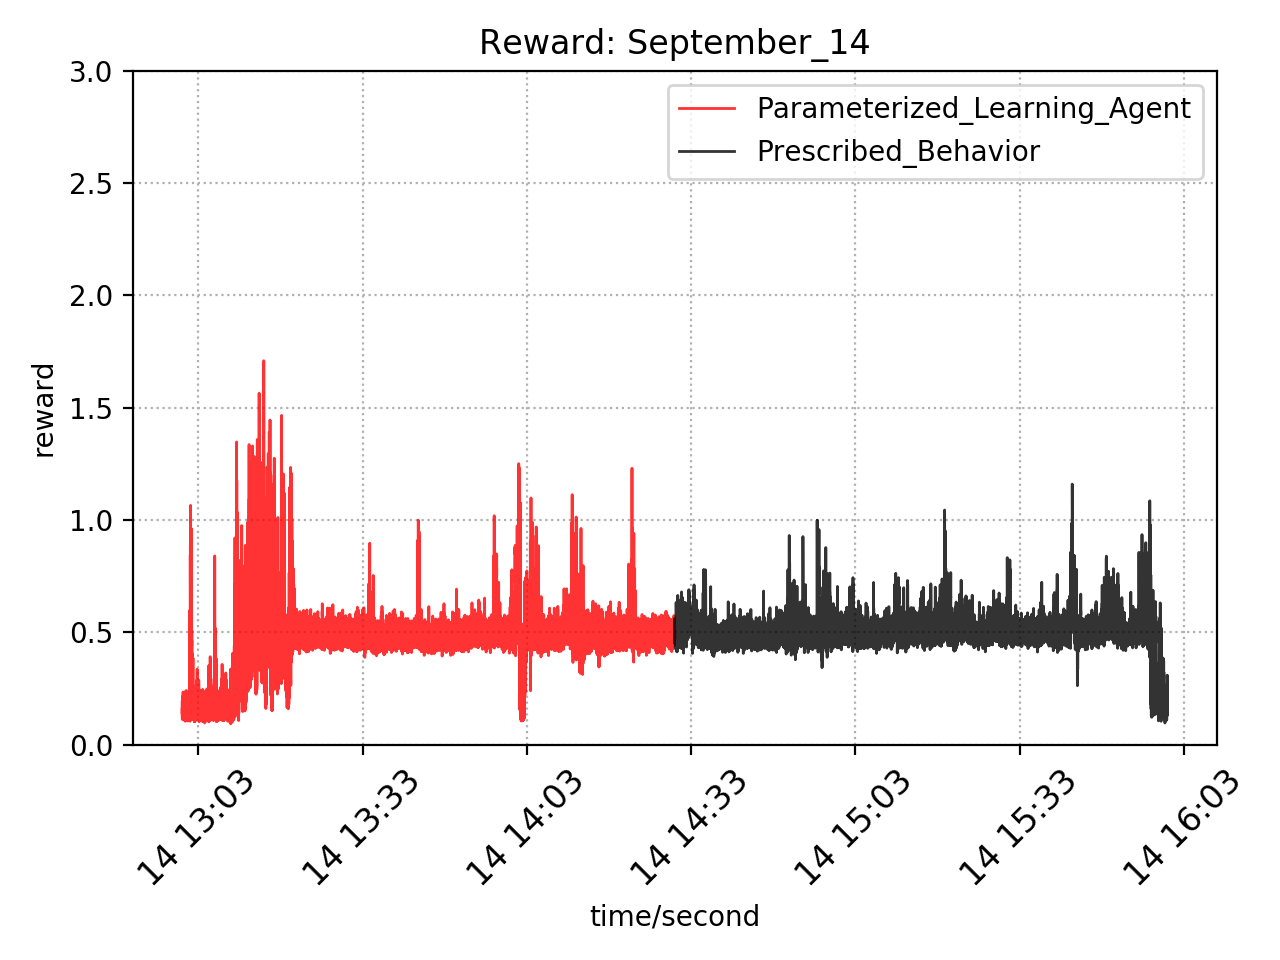

<IPython.core.display.Javascript object>


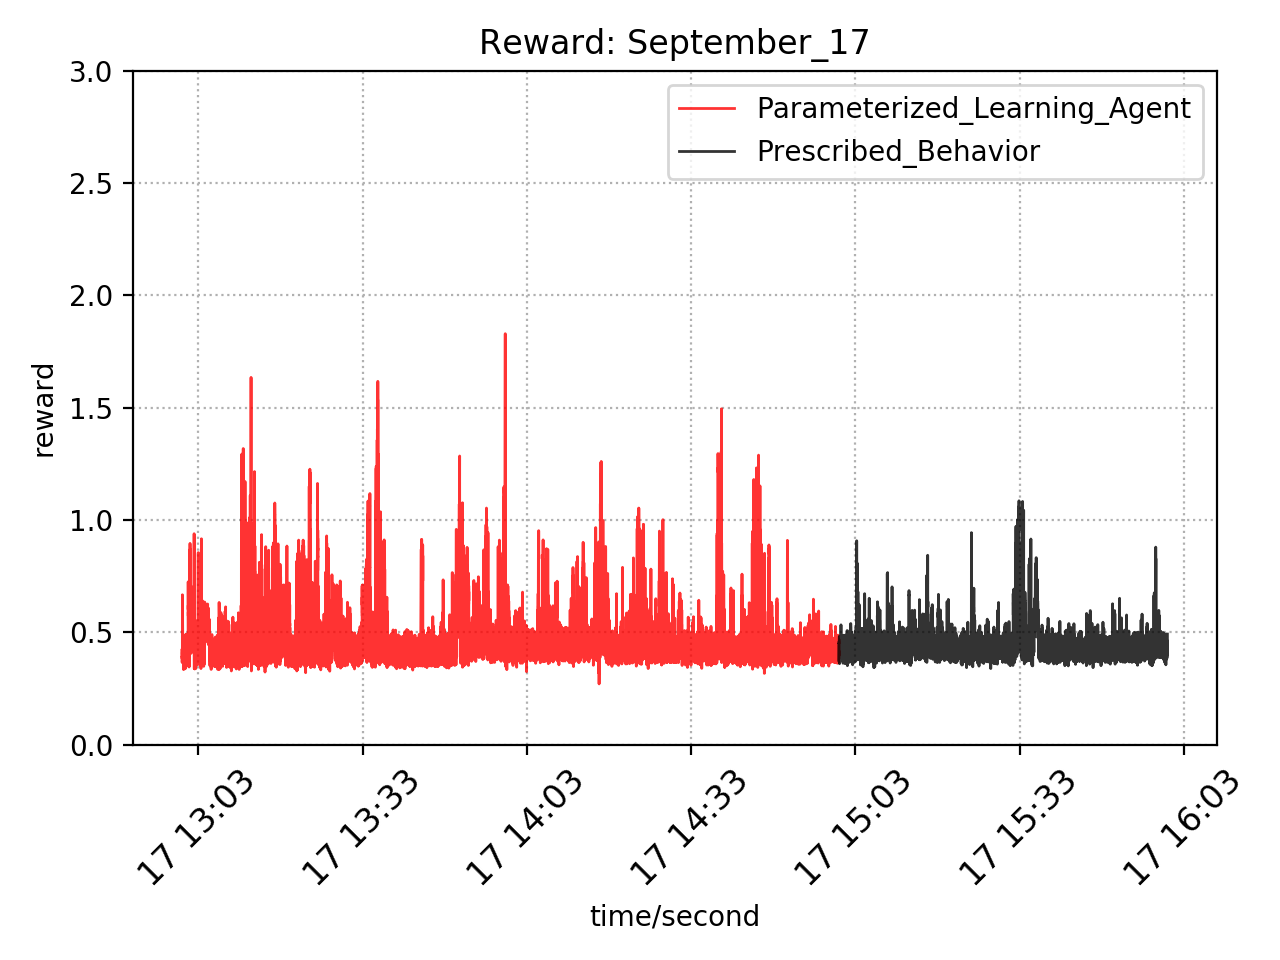

<IPython.core.display.Javascript object>


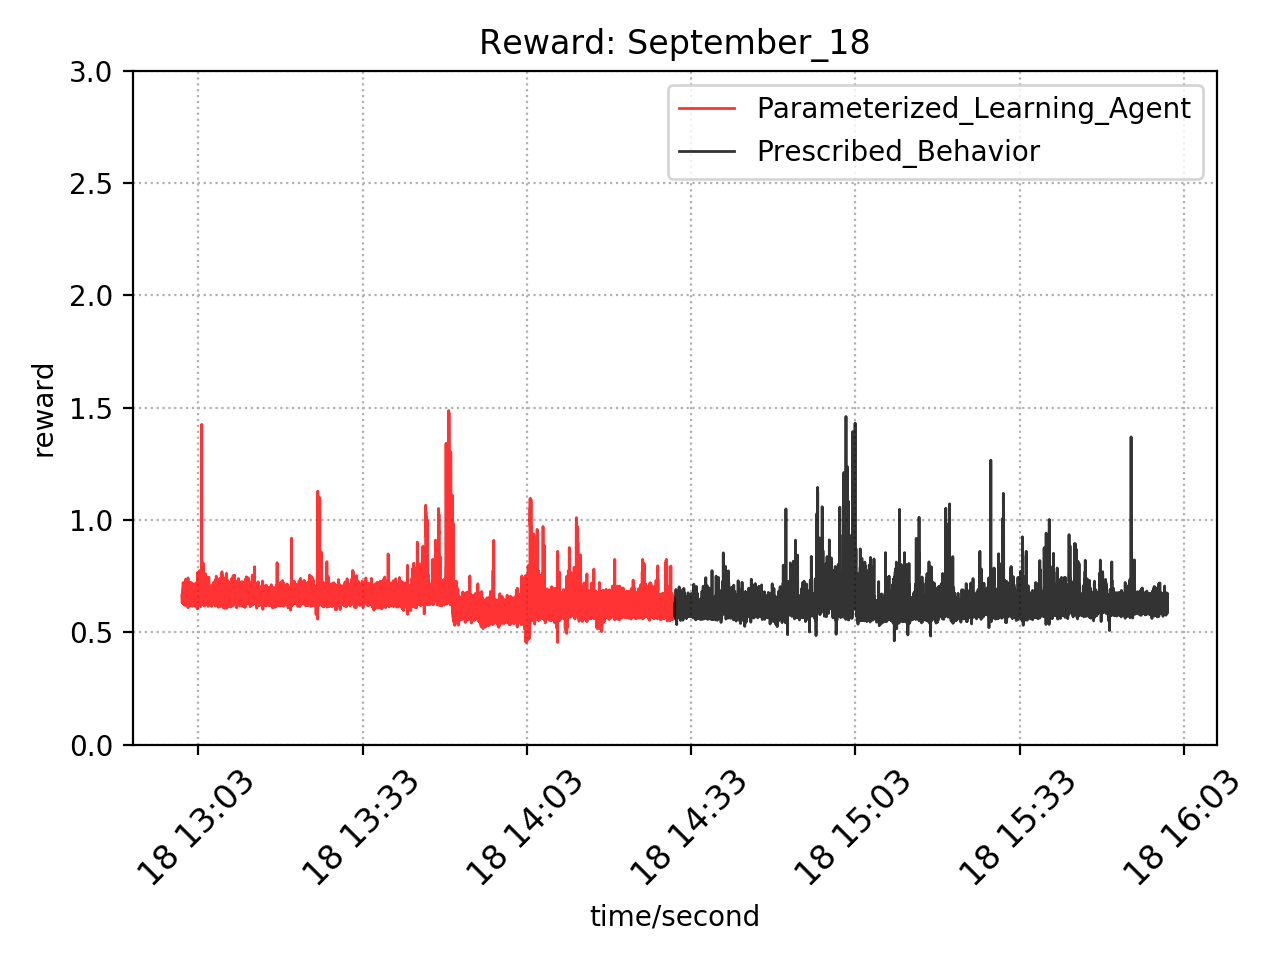

<IPython.core.display.Javascript object>


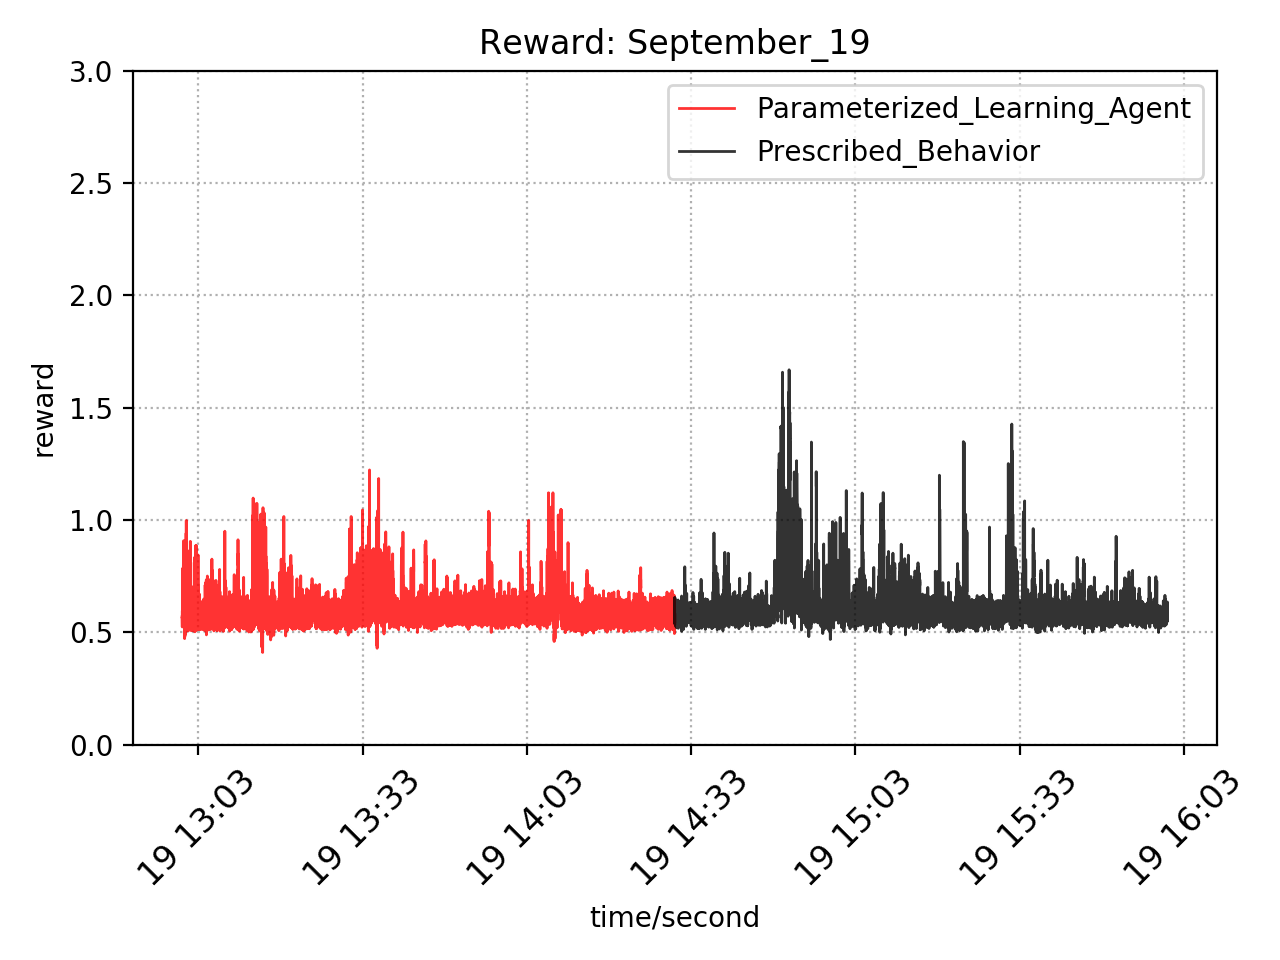

<IPython.core.display.Javascript object>


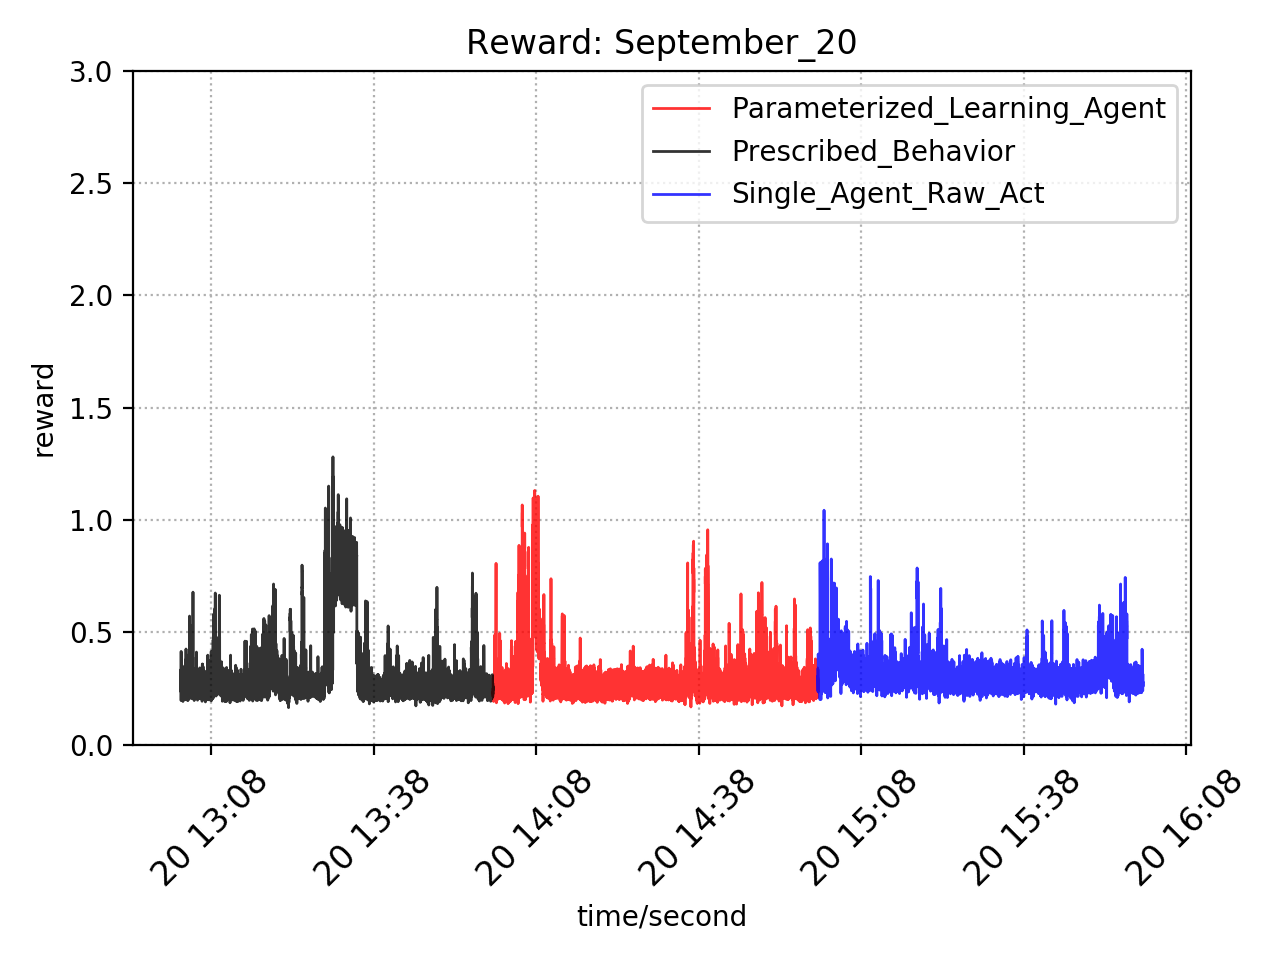

<IPython.core.display.Javascript object>


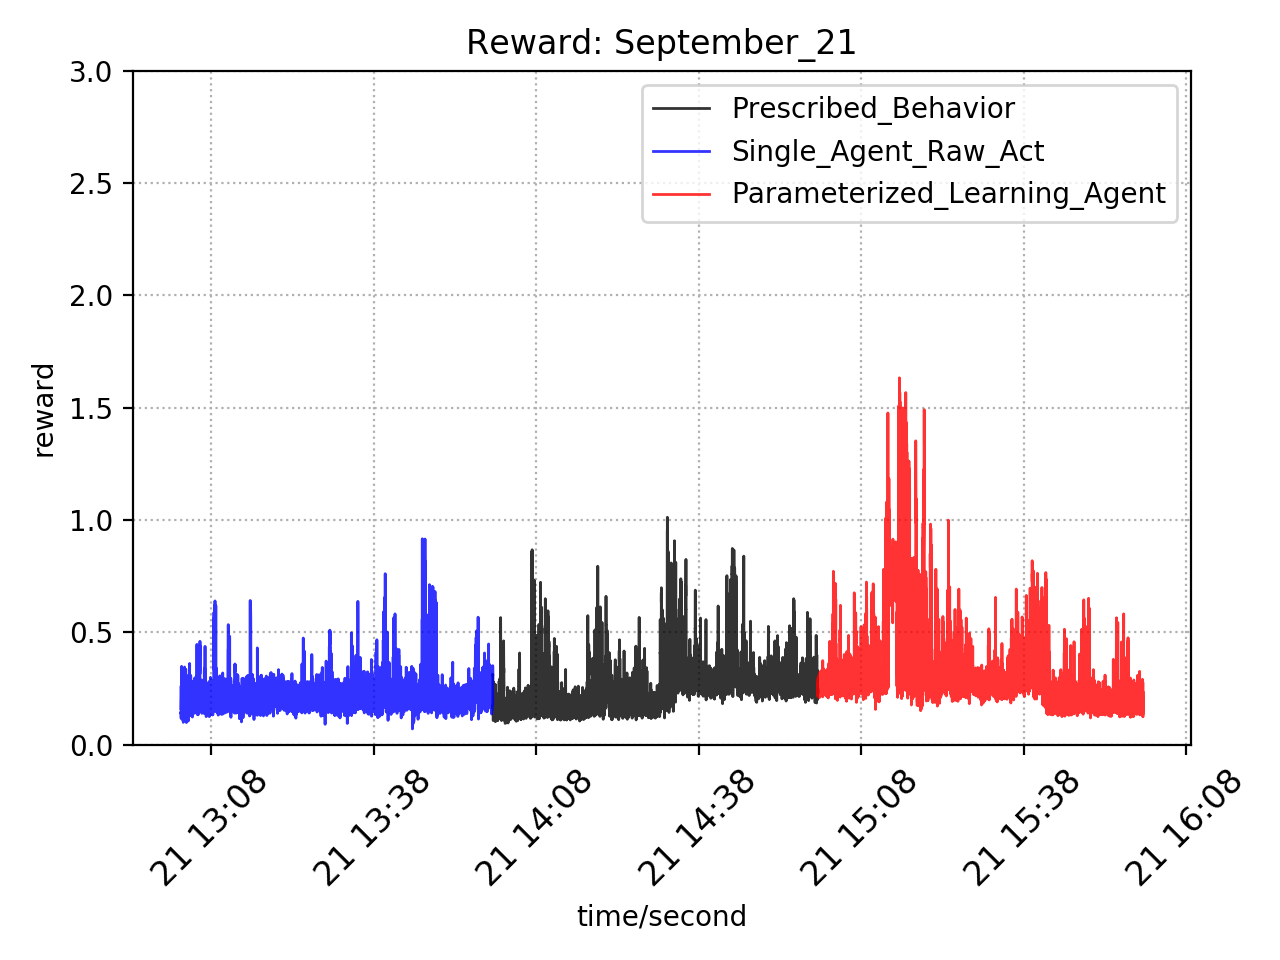

<IPython.core.display.Javascript object>


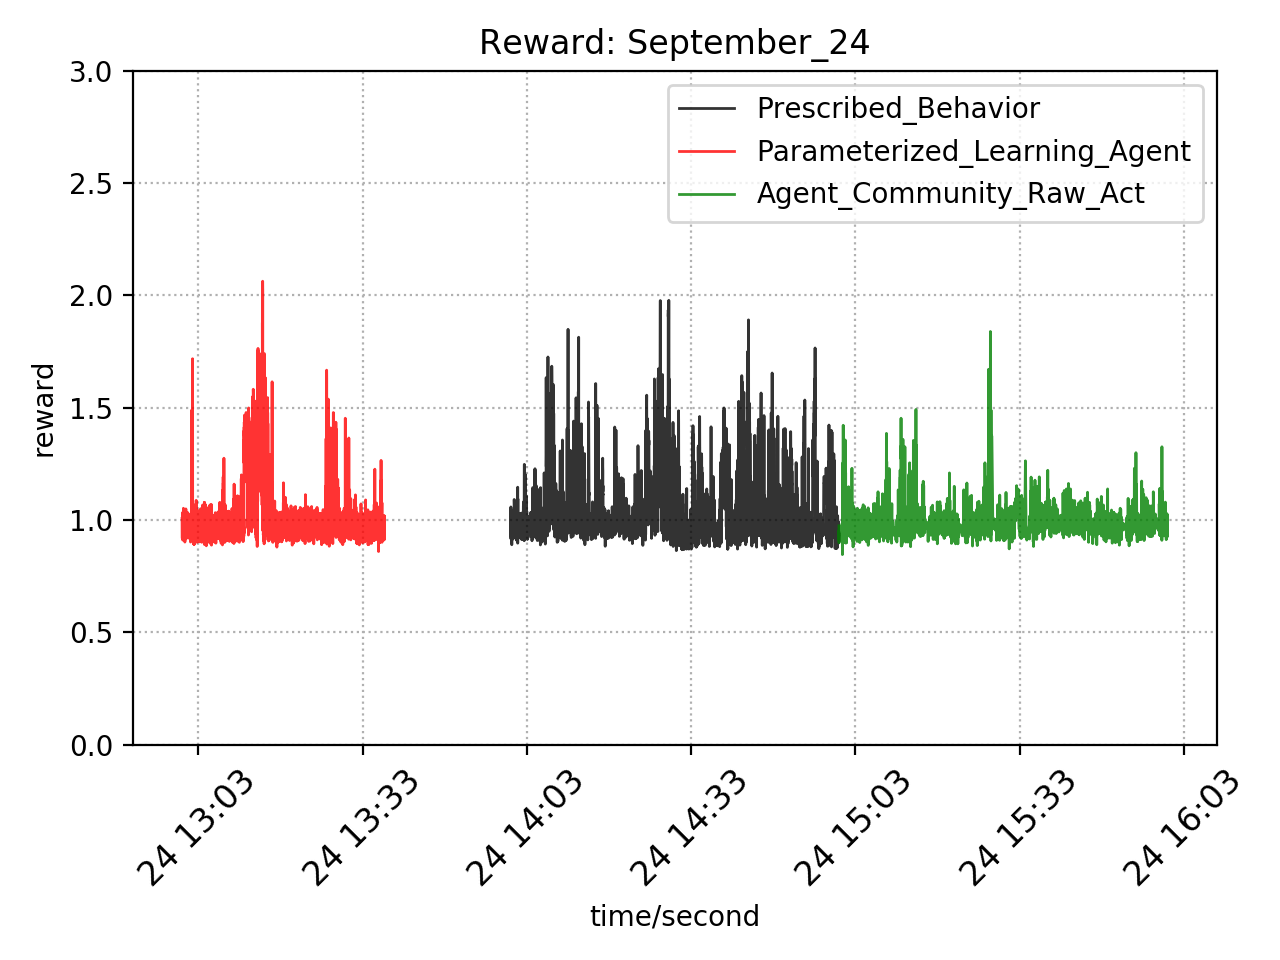

<IPython.core.display.Javascript object>


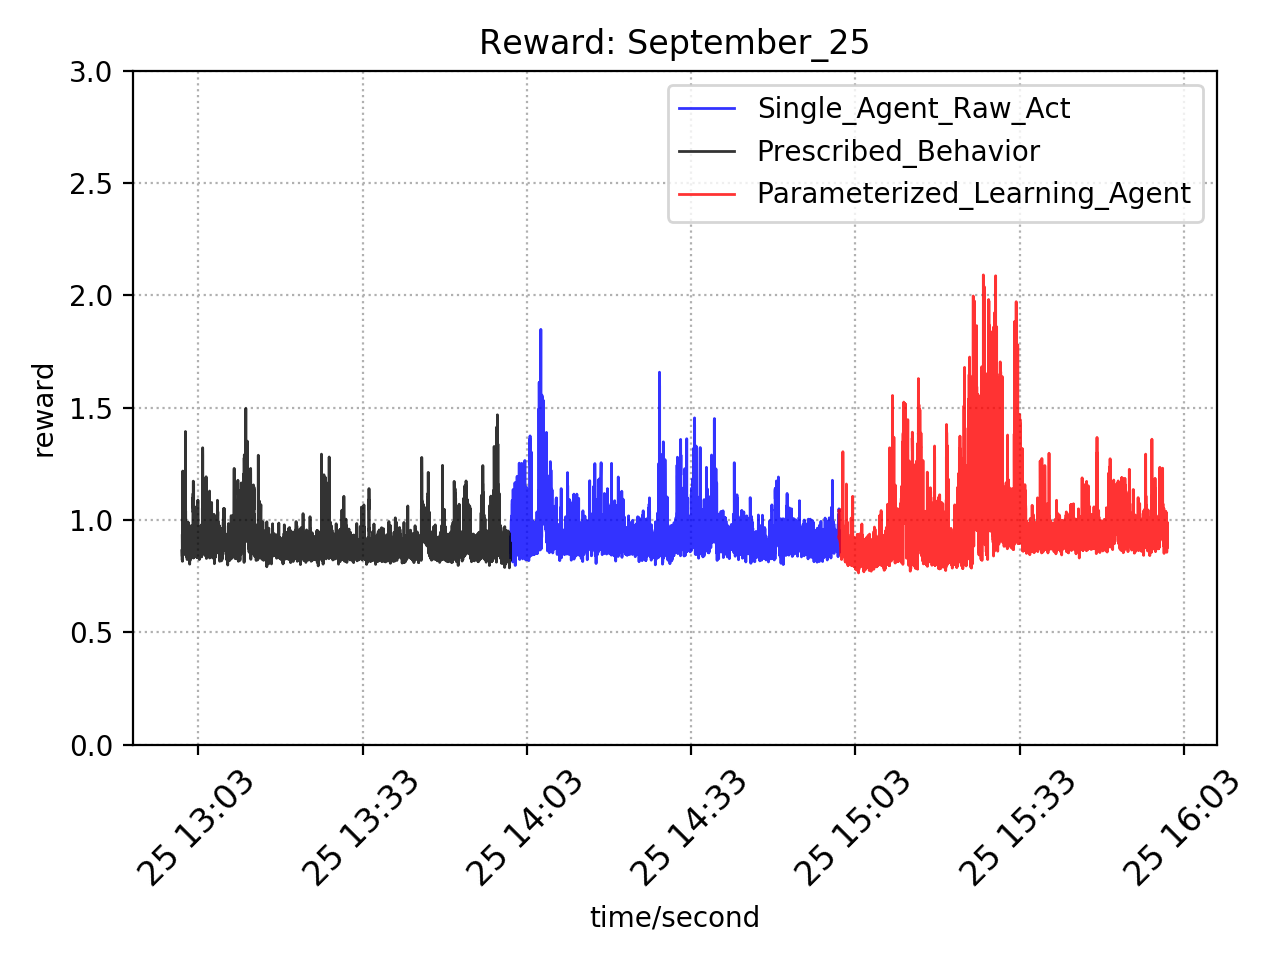

<IPython.core.display.Javascript object>


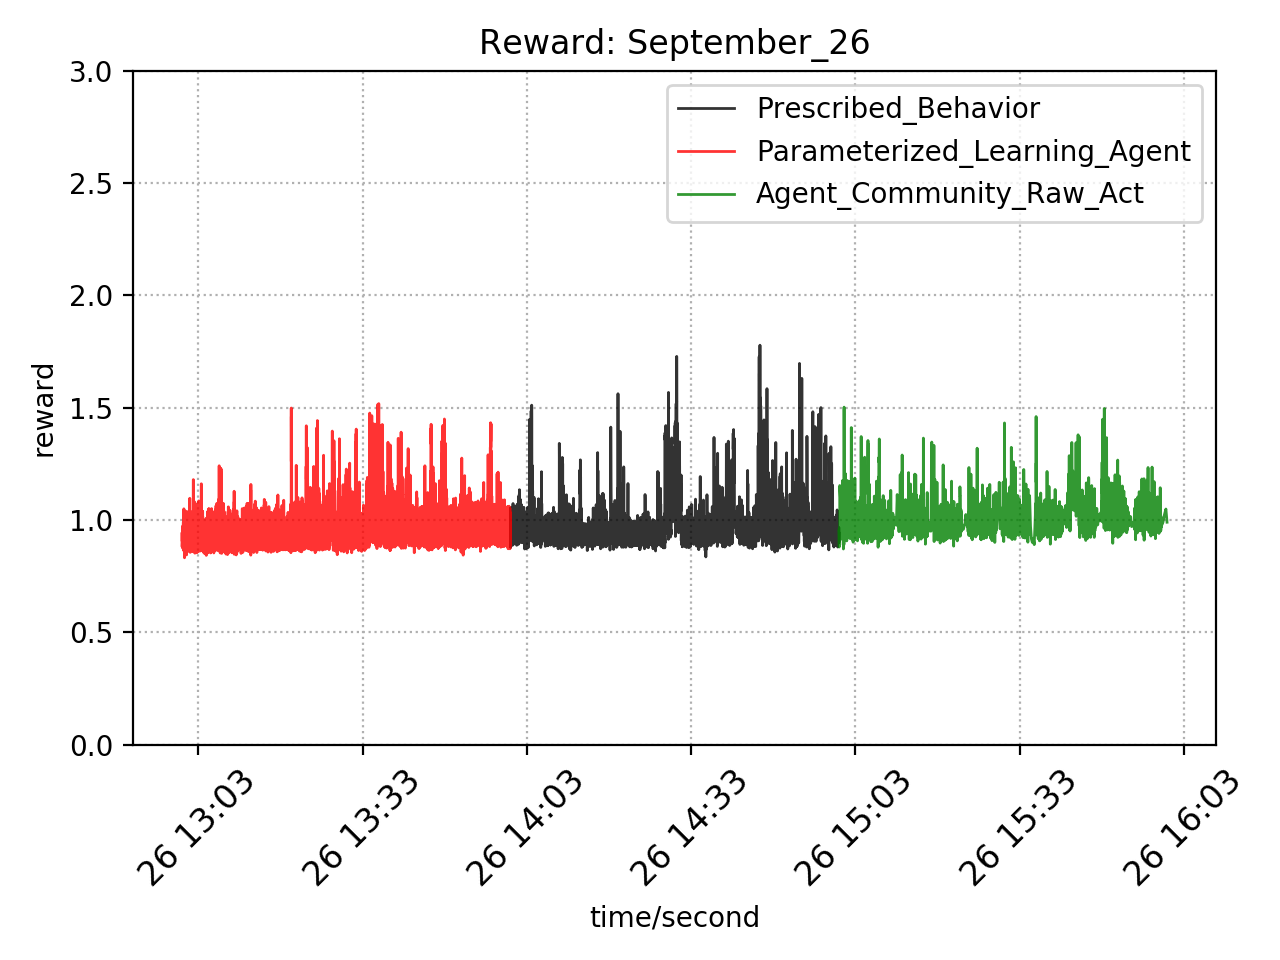

<IPython.core.display.Javascript object>


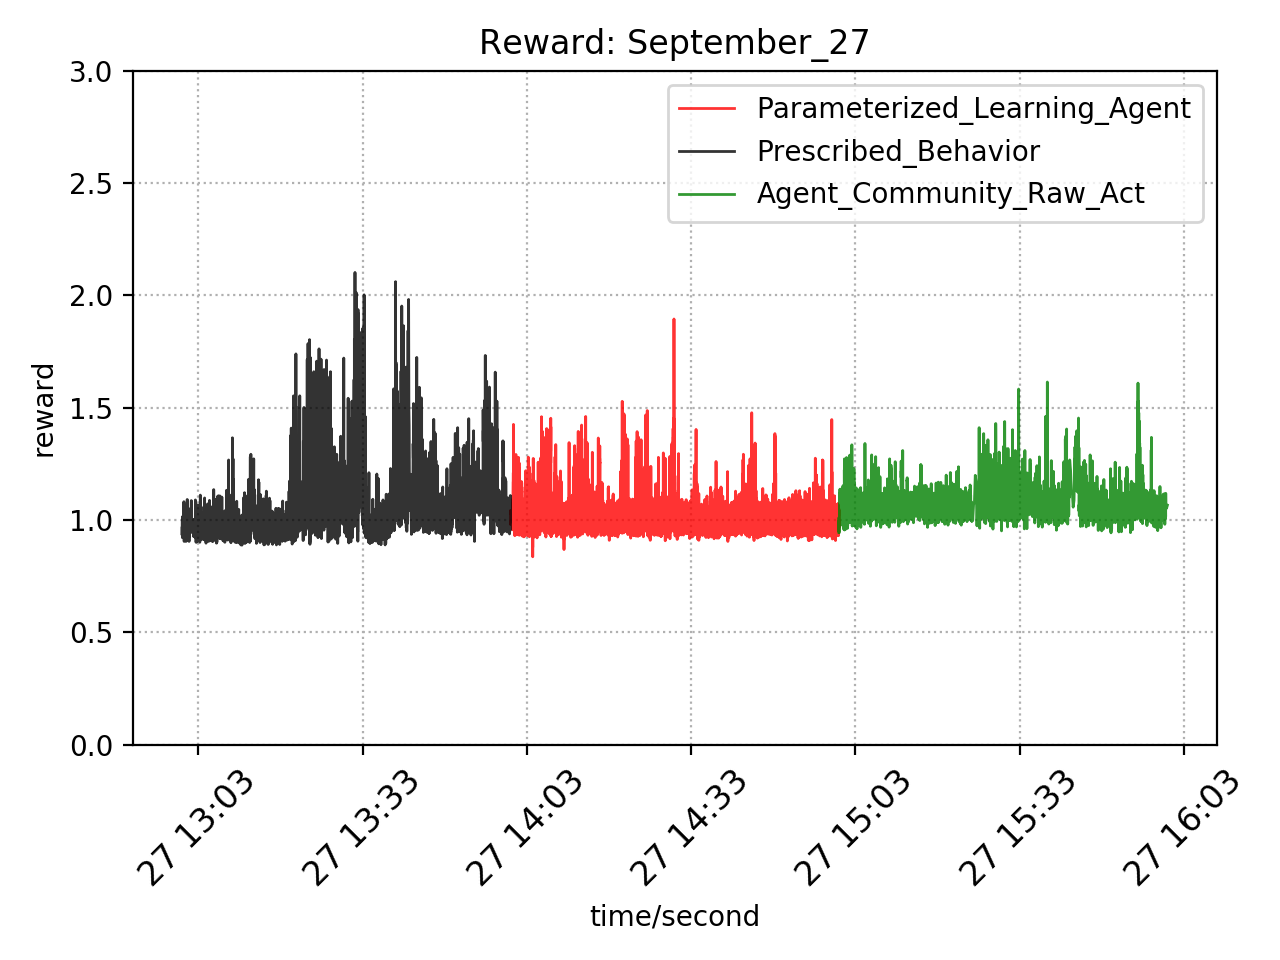

<IPython.core.display.Javascript object>


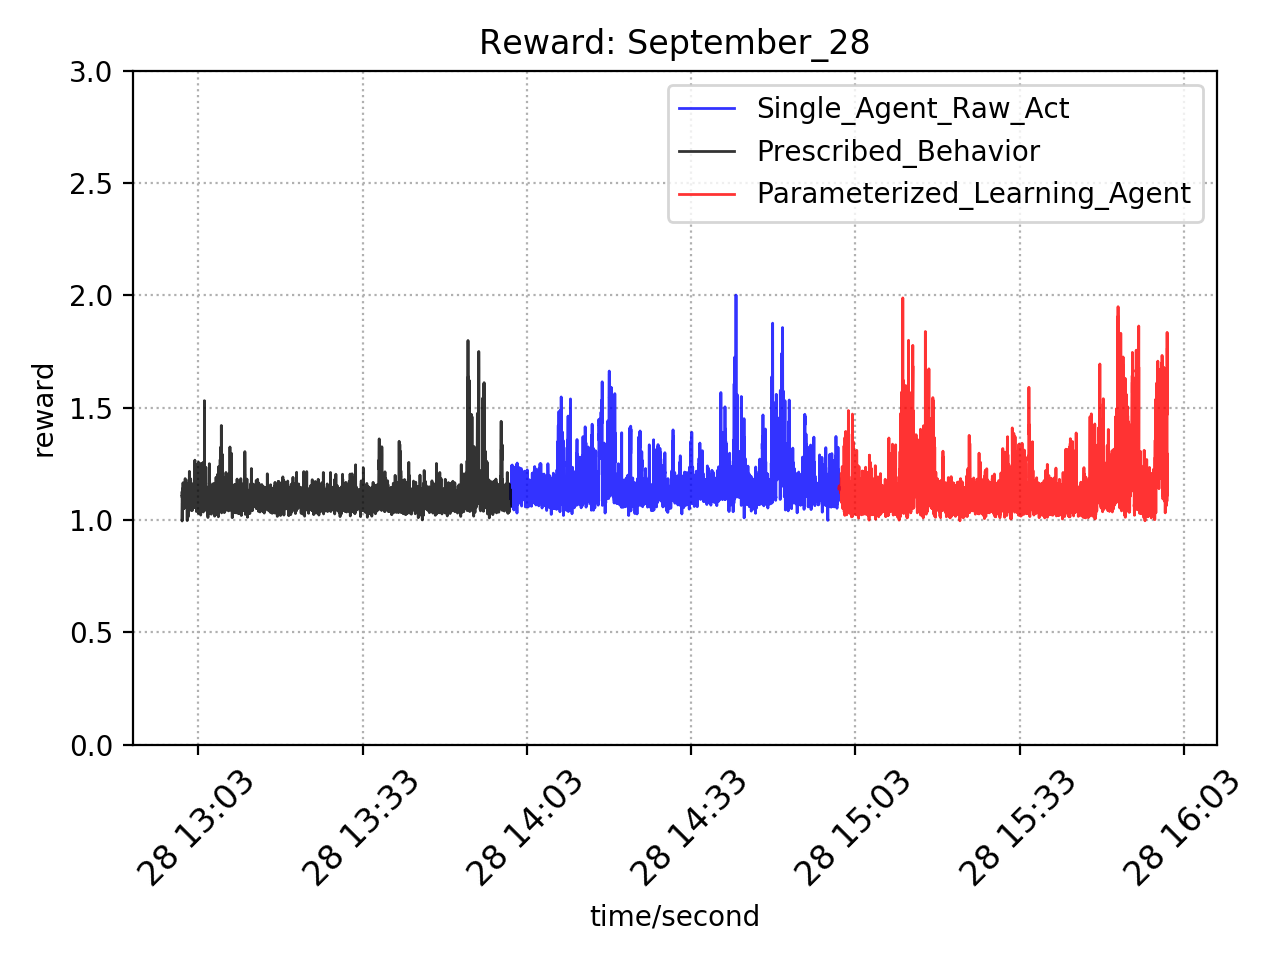

In [6]:
for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    plot_reward_signal(raw_sensor_data[file], filename)

## Concate Data from the Same Behavior Mode

In [7]:
prescribed_behavior = {}
prescribed_behavior['data'] = pd.DataFrame()
prescribed_behavior['separate_line'] = []
prescribed_behavior['date'] = []

para_learning_agent = {}
para_learning_agent['data'] = pd.DataFrame()
para_learning_agent['separate_line'] = []
para_learning_agent['date'] = []

single_agent_raw_act = {}
single_agent_raw_act['data'] = pd.DataFrame()
single_agent_raw_act['separate_line'] = []
single_agent_raw_act['date'] = []

agent_coummunity_raw_act = {}
agent_coummunity_raw_act['data'] = pd.DataFrame()
agent_coummunity_raw_act['separate_line'] = []
agent_coummunity_raw_act['date'] = []

for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    _, date = filename.split('_2018')[0].split('sensor_data__')
    
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data[file], date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], phase_data[phase_name]])
            prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
            prescribed_behavior['date'].append(date.replace('September','Sep'))
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            para_learning_agent['data'] = pd.concat([para_learning_agent['data'], phase_data[phase_name]])
            para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
            para_learning_agent['date'].append(date.replace('September','Sep'))
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], phase_data[phase_name]])
            single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
            single_agent_raw_act['date'].append(date.replace('September','Sep'))
        else:                             # Agent_Community_Raw_Act
            agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], phase_data[phase_name]])
            agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
            agent_coummunity_raw_act['date'].append(date.replace('September','Sep'))
    

<IPython.core.display.Javascript object>


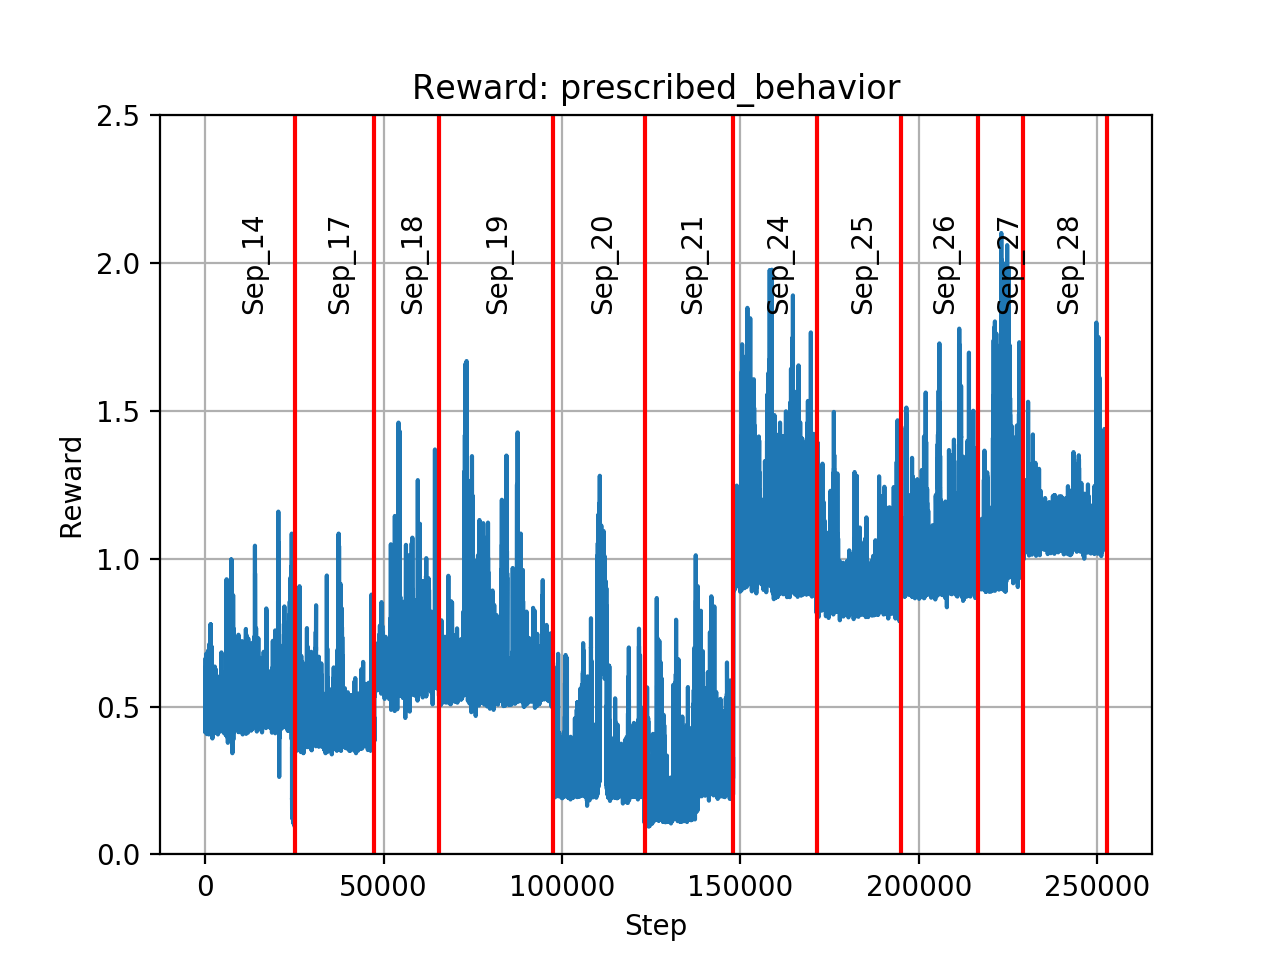

<IPython.core.display.Javascript object>


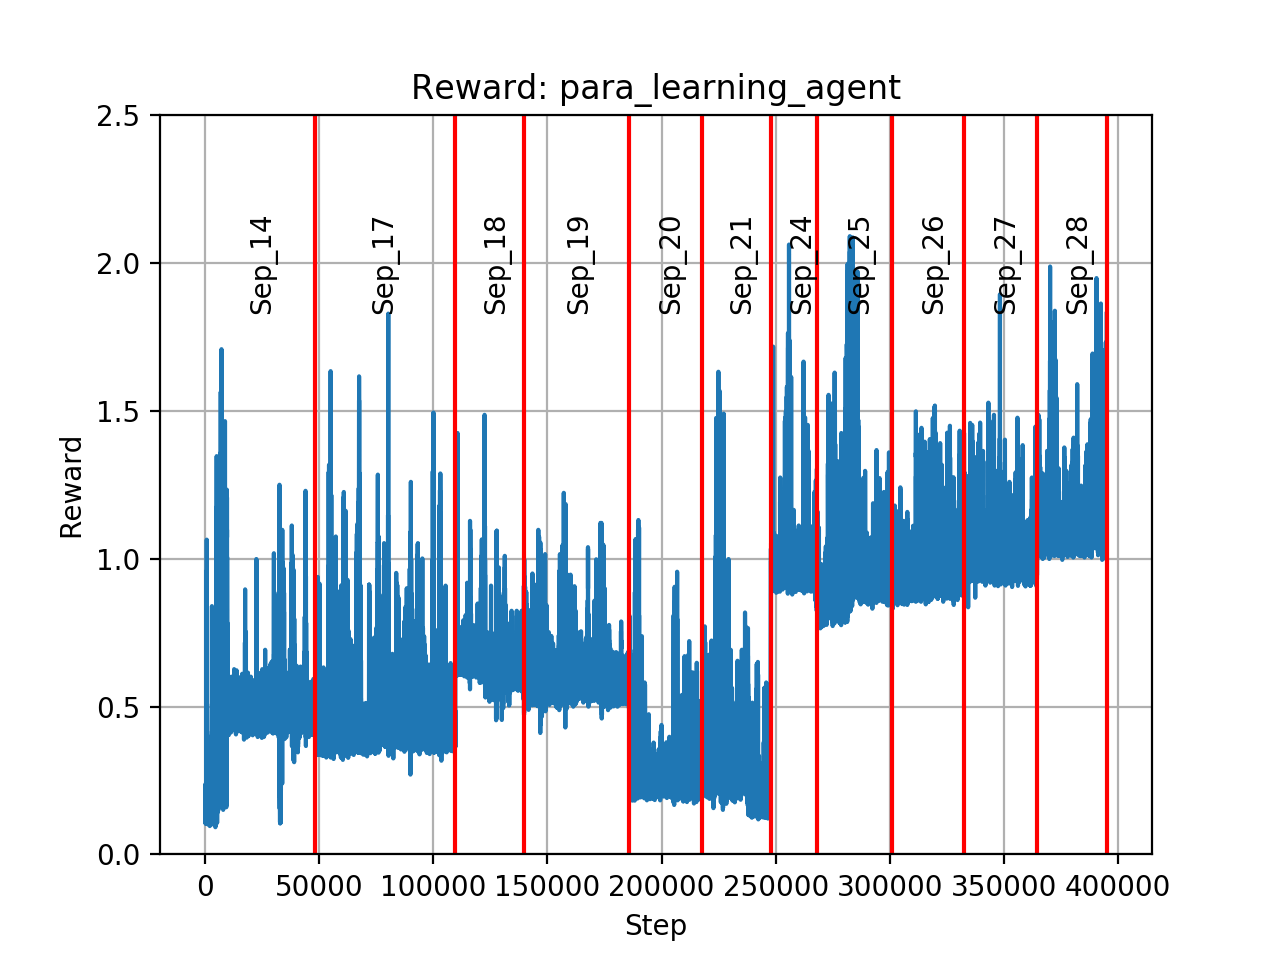

<IPython.core.display.Javascript object>


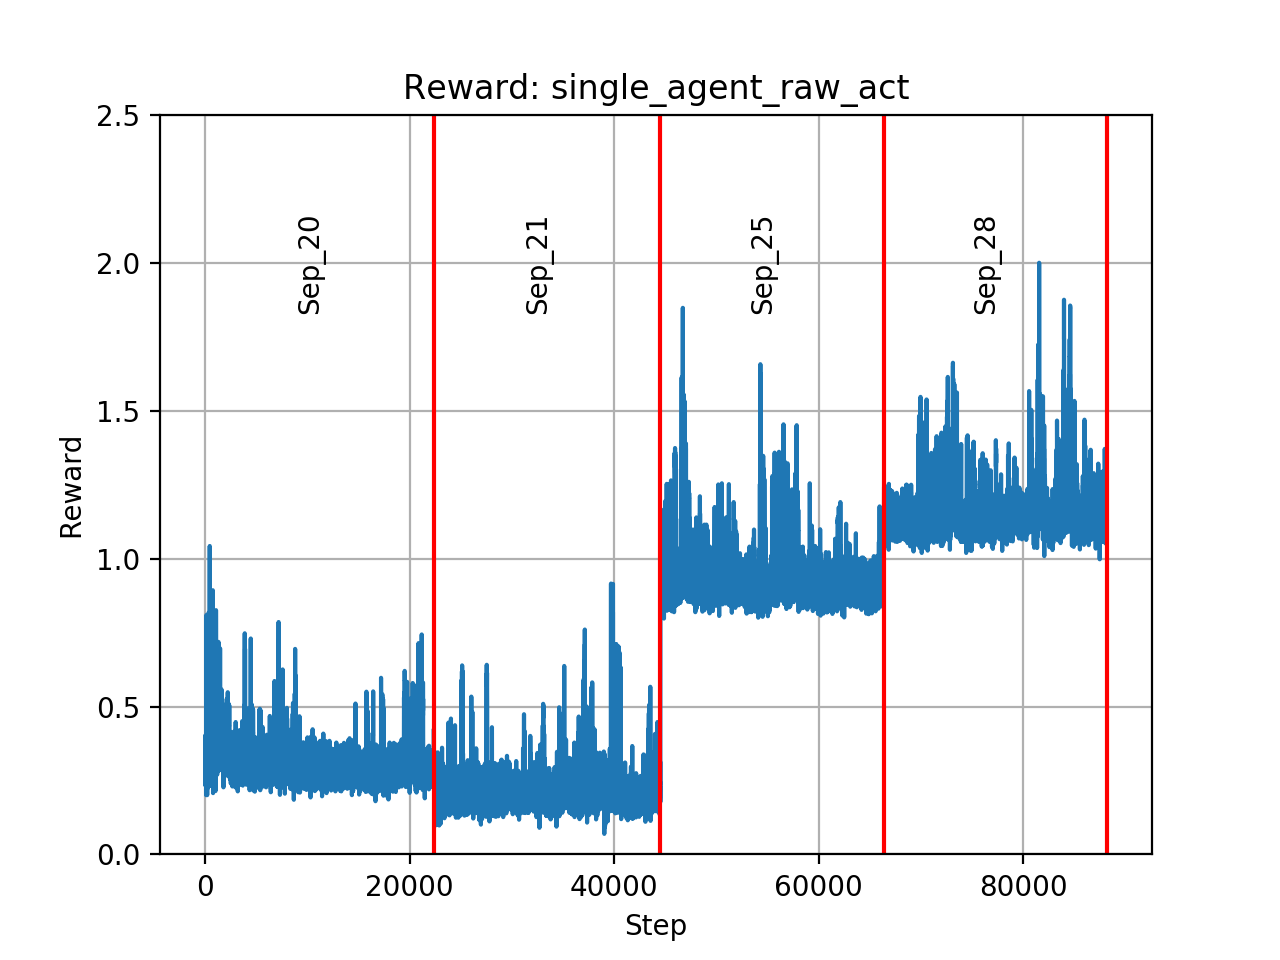

<IPython.core.display.Javascript object>


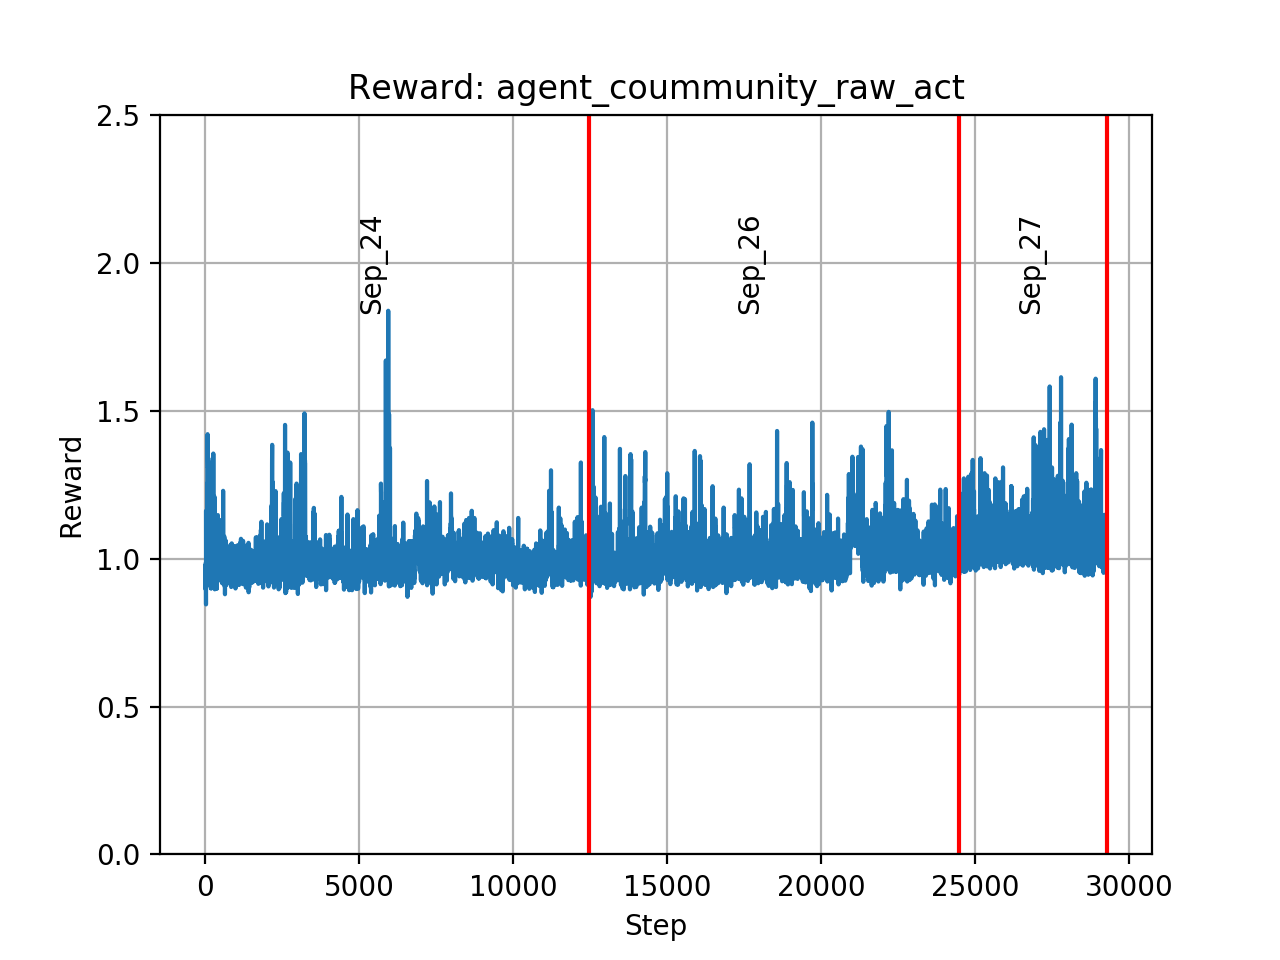

In [8]:
def plot_reward_from_one_behavior_mode(data, behavior_mode):
        plt.figure()
        plt.plot(np.arange(len(data['data']['reward_IR_distance'])), data['data']['reward_IR_distance'])
        plt.xlabel('Step')
        for i, separate_line in enumerate(data['separate_line']):
            plt.axvline(x = separate_line, color = 'r')
            if i == 0:
                middle = data['separate_line'][i]*0.4
                plt.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
            else:
                middle = data['separate_line'][i-1]+(data['separate_line'][i]-data['separate_line'][i-1])*0.4
                plt.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
        plt.ylabel('Reward')
        plt.ylim(0,2.5,0.25)
        plt.title('Reward: {}'.format(behavior_mode))
        plt.grid(True)
        #plt.tight_layout()

plot_reward_from_one_behavior_mode(prescribed_behavior, 'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 'agent_coummunity_raw_act')
    

## Normalize Reward with Estimated Occupancy from Openpose